# <a id='toc1_'></a>[Introduction to DEGM](#toc0_)

This notebooks illustrates how to use the DEGM algorithm presented in "An Endogenous Gridpoint Method for Distributional Dynamics" by Bayer, Luetticke, Weiss and Winkelmann (2024).

**Table of contents**<a id='toc0_'></a>    
- [Setup Environment](#toc2_)    
- [The Model](#toc3_)    
- [Finding the Stationary Distribution using DEGM](#toc4_)    
- [DEGM in Detail](#toc5_)    
- [Finding the Stationary Distribution in Detail](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Setup Environment](#toc0_)
If you did not setup the environment yet, please run the following cell. Note that Julia 1.10.2 is required.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\Admin2\Meine Ablage\GitHub\BASEtoolbox_KS_DEGM`


# <a id='toc3_'></a>[The Model](#toc0_)
We illustrate the method using an Aiyaragi (1994) economy:

\begin{align}
	& \max_{\{c_{t},k_{t+1}\}^{\infty}_{t=0}} \mathbb{E}\sum\limits_{t=0}^{\infty}\beta^{t} u(c_{t}) \\
	& \text{s.t. } c_{t}+k_{t+1}=\left( 1 + r_{t} - \delta_t  \right) k_{t}+h_{t}w_{t} \\
	& k_{t+1} \geq 0 
\end{align}

Labor is supplied inelastically. The wage and capital rates are given by the marginal products of labor and capital, respectively, where the production function is given by: 
\begin{align}
	Y_{t}&=K_{t}^{\alpha}N^{1-\alpha}
\end{align}

In [2]:
# Change directory to source code. Run only once per use of notebook!
cd("./src")

In [3]:
# Pre-process user inputs for model setup
include(joinpath(pwd(), "Preprocessor", "PreprocessInputs.jl"))
include(joinpath(pwd(), "BASEforHANK.jl"))
using Plots, PCHIPInterpolation
using .BASEforHANK   

Preprocessing Inputs ...
Done!


In [4]:
# Initliazation of parameters for the economy
m_par = BASEforHANK.ModelParameters();
n_par = BASEforHANK.NumericalParameters();

# <a id='toc4_'></a>[Finding the Stationary Distribution using DEGM](#toc0_)

The DEGM algorithm can be used to iterate the distribution forward. By iterating on the distribution until convergence, we can get the stationary distribution.
Before we do this, we first need a guess for capital and the policy function. Below, find the optimal policy function given a guess for capital.

In [5]:
include(joinpath(pwd(), "Model", "IncomesETC", "fcn_util_etc.jl"))
include(joinpath(pwd(), "Model", "IncomesETC", "fcn_incomes.jl"))

K_guess = 30.0

# Prices that will enter the household problem
N = m_par.N
r = interest(K_guess, 1.0, N, m_par) + 1.0
w = wage(K_guess, 1.0, N, m_par)
# Incomes given prices
inc = incomes(n_par, m_par, r, w, N)
# Human capital transition
Π = n_par.Π
# Guesses for the value function
c_guess = inc[1] .+ inc[2]
Vm = r .* mutil(c_guess, m_par);

# Find steady state policies given the interest rate guess
c_n_star, m_n_star, Vm, m_star_n = SteadyState.find_ss_policies(r, n_par, m_par, Vm, inc);

EGM Iterations: 2560
EGM Dist: 8.526512829121202e-14


Given the optimal policies and an initial guess, we can use the DEGM algorithm to iterate on the distribution until the stationary distribution is found.

In [6]:
# Use unformly distribution as initial guess for the stationary distribution
CDF_guess = n_par.CDF_guess
# Find stationary distribution given optimal policy.
CDF_joint = SteadyState.find_ss_distribution_splines(m_n_star, CDF_guess, n_par);

Distribution Iterations: 20673
Distribution Dist: 9.992007221626409e-14


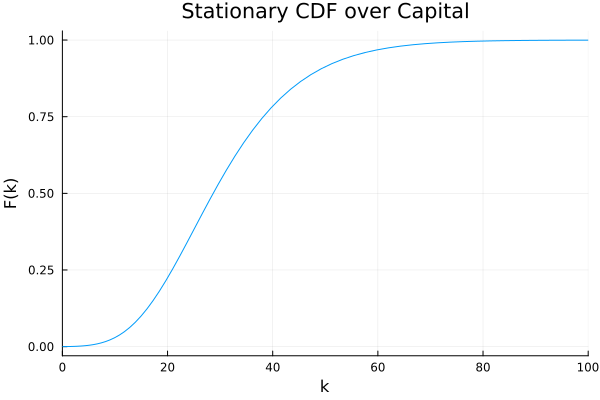

In [7]:
# Get CDF over capital and plot it over the savings grid
CDF_m = sum(CDF_joint, dims=2)
plot(n_par.grid_m, CDF_m, ylabel="F(k)", xlabel="k", title="Stationary CDF over Capital", legend=false, xlimits=(0,100))

We can calculate aggregate capital through integration of the distribution over capital:
$$
K = k_{max}F(k_{max}) - k_{min}F(k_{min}) + \int_{k_{min}}^{k_{max}} F(k) dk
$$

In [8]:
# Calculate capital stock
CDF_m = sum(CDF_joint, dims=2)[:]
K = SteadyState.integrate_capital(CDF_m, n_par)
println("Aggregate capital: $(round(K, digits=2))")

Aggregate capital: 30.54


# <a id='toc5_'></a>[DEGM in Detail](#toc0_)

We start with a guess for the distribution $F_{t}$ on the grid for capital savings $\mathcal{A}$ and savings $\mathcal{Y}$ and the policy function $a'=a^*(a,\mathcal{Y}_j)$.

Households a at a given gridpoint make their savings decision based on the policy function $a^*(a,\mathcal{Y}_j)$, s.t. the mass of households at a gridpoint $a$ with income $\mathcal{Y}_j$ shifts to $a'$ at the end of the period. Thus, the policy $a^*(a)$ gives us the endogenous gridpoints $\left\{\mathcal{A}^*_{i,j} \right\}$ for which we know the end of period distribution $\overset{\sim}{F}_{t}(\mathcal{A}^*_i,\mathcal{Y}_j)$.

However, we want to evaluate the end of period distribution at the fixed gridpoints $\mathcal{A}$, such that we need to interpolate the distribution from the endogenous gridpoints to the fixed gridpoints.

In [9]:
# Starting point for the cumulative joint distribution in capital discretized on the grid
CDF_start = n_par.CDF_guess
# Initialize the cumulative joint distribution for next period
CDF_prime = zeros(size(CDF_guess))
# Define a policy function for savings on the grid of capital
m_prime = m_n_star;

**Step 1**: <br> For each income state, create an interpolant $\overset{\hat \sim}{F}_{t}$ for the end of period distribution.

**(a)** Find the last endogenous state $\underline{a}_j$ for which the policy $a^*(a,\mathcal{Y}_j)$ is constant. 

Saving decisions below this point are never reached and $\overset{\sim}{F}_{t}$ is zero at those points.

In [10]:
# income state
j = 1
# get policy given the income state
m_prime_given_y = m_prime[:, j];
# get the distribution given the income state
cdf_prime_given_y = CDF_start[:, j];

In [11]:
# Find the index of the last point where the borrowing constraint binds
idx_last_at_constraint = findlast(m_prime_given_y .== n_par.grid_m[1])
# Find cdf_prime_given_y where the maximum cdf is reached to ensure strict monotonicity
idx_last_increasing_cdf = findlast(diff(cdf_prime_given_y) .> eps())
# store maximum savings for later
m_at_max_cdf = m_prime_given_y[end]
if idx_last_increasing_cdf !== nothing
    m_at_max_cdf = m_prime_given_y[idx_last_increasing_cdf + 1] # idx+1 as diff function reduces dimension by 1
end;

**(b)** + **(c)**: Discard all gridpoints below $\underline{a}_j$ from the set of gridpoints and the corresponding choices and create the interpolant $\overset{\hat \sim}{F}_{t}$ based on the selected set.

In [12]:
if isnothing(idx_last_at_constraint)
    m_to_cdf_spline = Interpolator(m_prime_given_y, cdf_prime_given_y)
else
    m_to_cdf_spline = Interpolator(m_prime_given_y[idx_last_at_constraint:end],
                                       cdf_prime_given_y[idx_last_at_constraint:end])
end;

**Step 2**: <br>
 Loop over all capital and income states and interpolate given 
 $$
 \hat{\tilde{\mathbf{F}}}_t(i,j) = \begin{cases}
		0 & \text{if } \mathcal{A}_i < \min \left\{\mathcal{A}^*_{i,j} \right\}\\
		\mathbf{F}_t(end,j) &\text{if }\mathcal{A}_i>\max \left\{\mathcal{A}^*_{i,j} \right\}\\
				\hat{\tilde F}^j_t(\mathcal{A}_i) & \text{else } 
	\end{cases}
$$


**(a)** Define interpolation function $\hat{\tilde{\mathbf{F}}}_t(i,j)$ <br>

In [13]:
# Extrapolation for values below and above observed a_primes and interpolation as defined above otherwise
function m_to_cdf_spline_extr!(cdf_values::AbstractVector, 
    m::Vector{Float64})
    idx1 = findlast(m .< m_prime_given_y[1])
    if idx1 != nothing
        cdf_values[1:idx1] .= 0.0
    else
        idx1 = 0
    end
    idx2 = findfirst(m .> min(m_at_max_cdf,m_prime_given_y[end]))
    if idx2 != nothing
        cdf_values[idx2:end] .= 1.0 * cdf_prime_given_y[end]
    else
        idx2 = length(m)+1
    end
        cdf_values[idx1+1:idx2-1] .= m_to_cdf_spline.(m[idx1+1:idx2-1])
end

m_to_cdf_spline_extr! (generic function with 1 method)

**(b)** Evaluate the interpolant to the grids $\mathcal{A}$ and $\mathcal{Y_j}$.

In [14]:
# Evaluate cdf at fixed grid
m_to_cdf_spline_extr!(cdf_prime_given_y,n_par.grid_m);

# Store in matrix for both income states
CDF_prime[:, 1] = cdf_prime_given_y;

Apply the same steps for the other income state(s).

In [15]:
# income state
j = 2
# get policy given the income state
m_prime_given_y = m_prime[:, j];
# get the distribution given the income state
cdf_prime_given_y = CDF_start[:, j];

# Do steps 1 an 2 (a)
SteadyState.DirectTransition_Cond_Splines!(
    cdf_prime_given_y,
    m_prime_given_y,
    n_par
)

CDF_prime[:, 2] = cdf_prime_given_y;


**Step 3**: Apply exogenous Markov transition to obtain the beginning of period distribution $\mathbf{F}_{t+1}$ as $${\mathbf{F}}_{t+1} = \hat{\tilde{\mathbf{F}}}_t \Pi'$$

In [16]:
CDF_prime .= CDF_prime * Π;

Now we have the beginning of period distribution $\mathbf{F}_{t+1}$.

# <a id='toc6_'></a>[Finding the Stationary Distribution in Detail](#toc0_)

Given the policy function $a^*(a)$, we can iterate on the distribution until the stationary distribution is found.

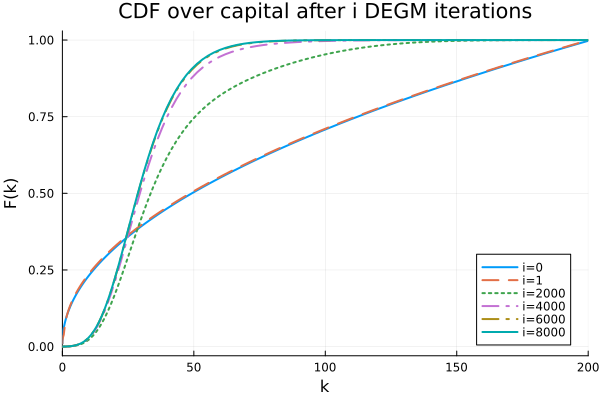

In [17]:
CDF_m = sum(CDF_start, dims=2)
CDF_m_prime = sum(CDF_prime, dims=2)

linestyles = [:solid, :dash, :dot, :dashdot, :dashdotdot]
p = plot(title="CDF over capital after i DEGM iterations", xlimits=(0,200))
plot!(p, n_par.grid_m, CDF_m, ylabel="F(k)", xlabel="k", label="i=0", linewidth=2, ls=linestyles[1])
plot!(p, n_par.grid_m, CDF_m_prime, label="i=1", linewidth=2, ls=linestyles[2])


i_ls = 2
# Iterate with distribution with DEGM (do not check for convergence)
max_iter = 8000
for i in 1:max_iter
    CDF_start = copy(CDF_prime)
    SteadyState.DirectTransition_Splines!(CDF_prime, m_prime, CDF_start, n_par.Π, n_par)
    CDF_m_prime = sum(CDF_prime, dims=2)
    if i % 2000 == 0
        plot!(p, n_par.grid_m, CDF_m_prime, label="i=$i", linewidth=2, ls=linestyles[i_ls%length(linestyles)+1])
        i_ls += 1
    end
end
display(p)